#### Ejercicio 2

El circuito de la figura corresponde amplificador "clase C" realizado con un MOSFET, para una portadora de 10 
MHz.

<img src="./fig/circuito1.png">

Para este proyecto se busca máxima excursión de señal, y el ángulo de circulación de corriente de Drain debe ser $\theta$  = 120º . 

Se asume la impedancia del dispositivo a su salida entre  Drain  y Source es lo suficientemente elevada como para desestimarla frente a la carga.

La tensión de excitación en Gate es absolutamente senoidal.
El Q cargado de ambos tanques (Gate y  Drain) es de 10 y el  $Q_{oL}$ de las bobinas es 100. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (12, 8),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params) 



In [32]:
def myFourier(armonicos, x, y, dt, Tm):
    y_f = list()
    for a in armonicos: 
        if a == 0 : 
            yf_o = 0.0
            for i,xi in enumerate(x):
                yf_o += y[i]*dt/Tm
            y_f.append(yf_o)
        else : 
            yf_ac = 0.0
            yf_as = 0.0

            for i,xi in enumerate(x):
                yf_ac += 2.*dt/Tm * y[i]*np.cos(2*np.pi*a*xi)
                yf_as += 2.*dt/Tm * y[i]*np.sin(2*np.pi*a*xi)
            y_f.append(yf_as+yf_ac)
    return y_f


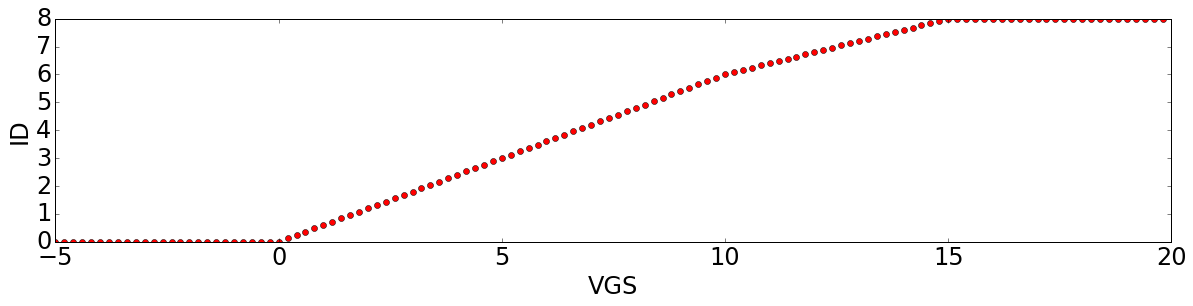

In [33]:
def vgsi(VGG,Vs,th):
    return VGG+Vs*cos(th)

def idi(v):
    i = 0. if (v < 0.)  else 0
    i = (6./10.)*(v-0.) if (v >= 0  and v < 10) else i
    i = (6+2./5*(v-10)) if (v >= 10 and v < 15 ) else i
    i = (8) if (v >= 15  ) else i
    return i
vgs = np.arange(-5.,20.,0.2)

ids = []
for v in vgs:
    ids.append(idi(v))
#%matplotlib inline
#plt.gca().cla()
plt.plot(vgs,ids,'ro')
#plt.axis([-10, 10, -1, 11])
plt.ylabel('ID')
plt.xlabel('VGS')
plt.rcParams['figure.figsize'] = (20.0, 4.0)
plt.show()

In [34]:
#parametros de la senal 
fc = 10
th_c = 120
#tiempo de un periodo de la modulante
Tc  = 1/fc

# muestreo (empleando 24 ya que corresponde a el muestreo del empleado comunmente en el metodo de los trapecios)
fs  =  fc*24
ds  = 1/(fs)

#parametros del filtro de salida
Qo = 100
Qc = 10

#parametros del transistor
Vds_min = 10 
Vds_max = 150

### Calculo de VGG y Vs 

Para máxima excursión de la señal y un ángulo de circulación de 120 grados, podemos plantear el siguiente sistema de ecuaciones:

$ VGG + Vs = 15 $

$ VGG + Vs\cdot cos(120) = 0 $


In [35]:
Vs  = 15 /(1-np.cos(th_c/2*np.pi/180))
VGG = 15 - Vs
print(' Vs = {:.2f}, VGG = {:.2f}'.format(Vs,VGG))

 Vs = 30.00, VGG = -15.00


Plot de la senal 

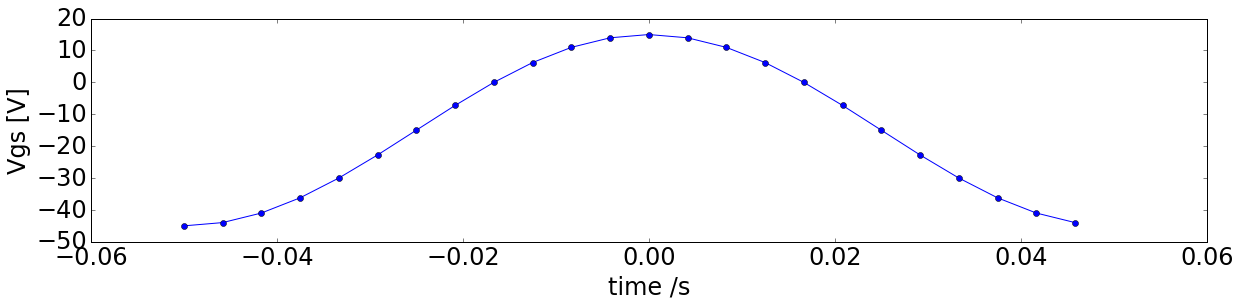

In [36]:
time = np.arange(-Tc/2,Tc/2,ds)
vgs = list()
for t in time:
    vgs.append(vgsi(VGG, Vs, 2*np.pi*fc*t))

plt.plot(time,vgs, 'bo-')
plt.xlabel('time /s')
plt.ylabel('Vgs [V]')
plt.show()

In [37]:
vin_f = list()

maxArmon = int(fs/fc)/2
armonicos = np.arange(0,fc*maxArmon,fc)

vin_f = myFourier(armonicos, time, vgs, ds, Tc)


(-10, 120)

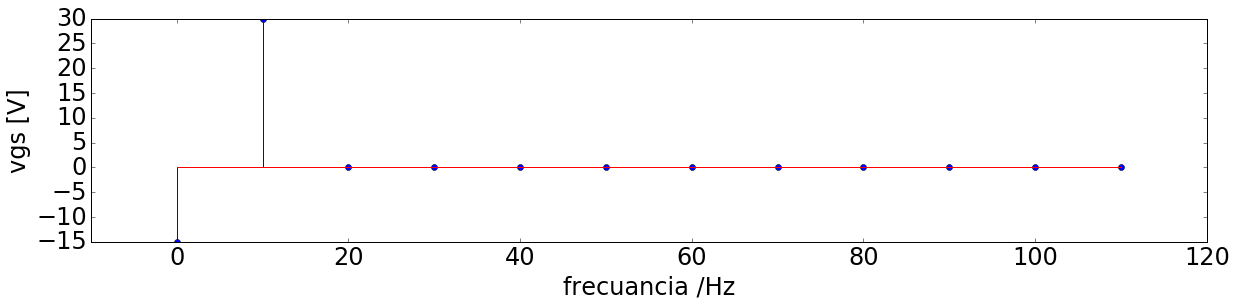

In [38]:
plt.stem(armonicos,vin_f) 
plt.xlabel('frecuancia /Hz')
plt.ylabel('vgs [V]')
plt.xlim([-10,120])


Corriente de salida del transistor 

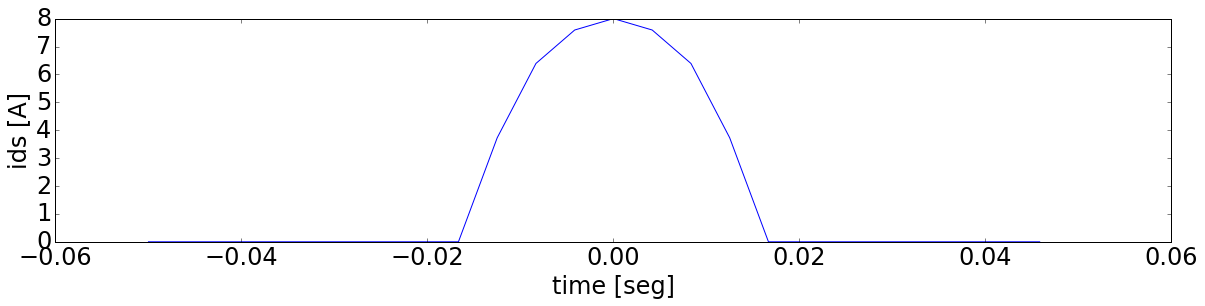

In [39]:
ids = []
for x,t in enumerate(time):
    ids.append(idi(vgs[x]))

plt.plot(time,ids)
plt.xlabel('time [seg]')
plt.ylabel('ids [A]')

Analisis de Fourier para la corriente de salida

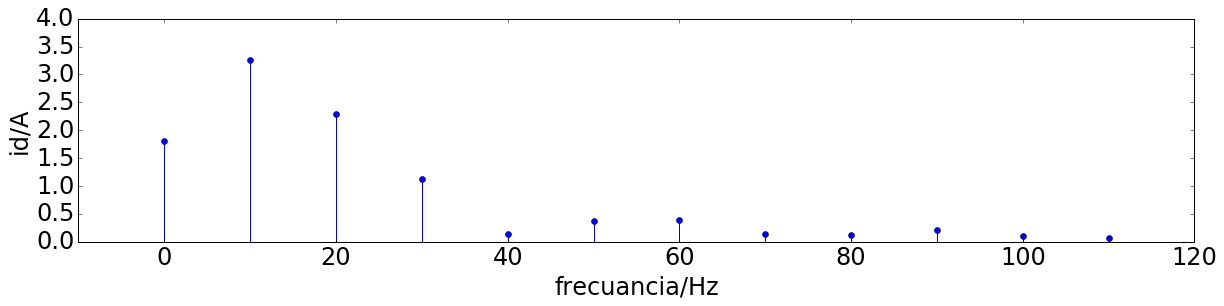

In [42]:
iout_f = myFourier(armonicos, time, ids, ds, Tc)

plt.stem(armonicos,(np.abs(iout_f[:]) ) )
plt.xlabel('frecuancia/Hz')
plt.xlim([-10,120])
plt.ylim([ 0,4])
plt.ylabel('id/A')

In [41]:
# Continua
idco = iout_f[0]


# primer arminico
idc1 = iout_f[1]

# segundo arminico
idc2 = iout_f[2]

# segundo arminico
idc3 = iout_f[3]

print('idco= {:.2f} A, idc1={:.2f} A, idc2={:.2f} A, idc3={:.2f} A '.format(idco,idc1,idc2,idc3) )



idco= 1.81 A, idc1=3.25 A, idc2=2.30 A, idc3=1.12 A 


In [27]:
#calculo de la resistencia de carga de salida teniendo la portadora en pico para el primer armonico de la modulante

VRL = (Vds_max -Vds_min ) /2 
VDD = Vds_max - VRL
RL  = VRL / idc1 

print('RL= {:.2f} ohm, VDD={:.2f} V'.format(RL,VDD) )


RL= 21.53 ohm, VDD=80.00 V


Calculo de las potencias

In [28]:
#Portadora
PDC = idco * VDD
PRL = idc1 * VDD / 2
PTR = PDC - PRL

print('PDC= {:.2f} W, PRL={:.2f} W, PTR={:.2f} W'.format(PDC,PRL,PTR) )

neff = PRL/PDC 
print('rendimiento = {:.2f} '.format(neff)  )

PDC= 144.74 W, PRL=130.03 W, PTR=14.71 W
rendimiento = 0.90 


Estos pulsos de corriente son filtrados por un simple sintonizado 

In [29]:
def SS(v ,f, Qc, fo):
    return v*np.abs(1/(1+(Qc*(f/fo-fo/f))**2)**0.5)

In [30]:
#calculo de la transferencia del filtro
vout_f = []
for x,i in enumerate(iout_f[1:]):
    
    vout_f.append(SS(i*RL,armonicos[x+1],Qc,fc))

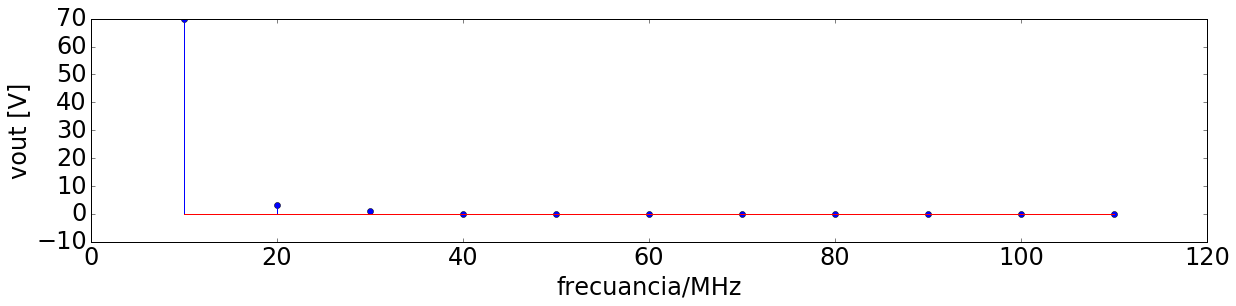

In [31]:
plt.stem(armonicos[1:],vout_f ) 
plt.xlabel('frecuancia/MHz')
plt.ylabel('vout [V]')